In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset

class CollectiveActivityDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir.replace("\\", "/")  # Ensure correct path format
        self.transform = transform
        self.sequences = []
        self.labels = set()  # Track unique class labels

        for seq in sorted(os.listdir(root_dir)):
            seq_path = os.path.join(root_dir, seq)
            if os.path.isdir(seq_path):
                annotation_file = os.path.join(seq_path, 'annotations.txt')
                if os.path.exists(annotation_file):
                    with open(annotation_file, 'r') as f:
                        for line in f:
                            line = line.strip().split()
                            if len(line) >= 6:
                                frame, x, y, w, h, class_id = line[:6]
                                try:
                                    class_id = int(class_id)
                                    
                                    # 🚨 Skip Walking (CLASS ID = 5)
                                    if class_id == 5:
                                        continue  

                                    # 🔥 Adjust CLASS ID to 0-based index (After Removing Walking)
                                    class_mapping = {2: 0, 3: 1, 4: 2, 6: 3, 7: 4, 8: 5}
                                    if class_id in class_mapping:
                                        new_class_id = class_mapping[class_id]
                                    else:
                                        
                                        continue  # Skip unexpected values

                                    self.labels.add(new_class_id)  # Collect unique labels
                                    img_path = os.path.join(seq_path, f"frame{frame.zfill(4)}.jpg")
                                    
                                    if os.path.exists(img_path):
                                        self.sequences.append((img_path, new_class_id))
                                    else:
                                        print(f"⚠️ Warning: Image file not found: {img_path}")
                                except ValueError:
                                    continue
                            else:
                                print(f"⚠️ Invalid annotation format: {line}")

        print(f"✅ Unique class labels after adjustment (excluding Walking): {sorted(self.labels)}")  # Debugging

    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        img_path, label = self.sequences[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label  


In [3]:
# ✅ Image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [4]:

# ✅ Simple CNN-RNN Model
class ActionRecognitionModel(nn.Module):
    def __init__(self, num_classes=6):
        super(ActionRecognitionModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.rnn = nn.LSTM(64 * 32 * 32, 128, batch_first=True)
        self.fc = nn.Linear(128, num_classes)
    
    def forward(self, x):
        batch_size, seq_length, c, h, w = x.size()
        x = x.view(batch_size * seq_length, c, h, w)
        x = self.cnn(x)
        x = x.view(batch_size, seq_length, -1)
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x

In [5]:


# ✅ Training function with best model saving
def train(model, dataloader, criterion, optimizer, device, epochs=10, model_path='CNN_LSTM_best_model.pth'):
    model.to(device)
    best_accuracy = 0.0
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct, total = 0, 0
        batch_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
        
        for images, labels in batch_bar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images.unsqueeze(1))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            batch_bar.set_postfix(loss=loss.item())
        
        accuracy = 100 * correct / total
        print(f"📌 Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader)}, Accuracy: {accuracy}%")
        # Save best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), model_path)
            print(f"🚀 Best model saved with Accuracy: {best_accuracy}%")

In [6]:

# ✅ Testing function with best model loading
def test(model, dataloader, device, model_path='CNN_LSTM_best_model.pth'):
    model.to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images.unsqueeze(1))
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"🎯 Best Model Accuracy: {100 * correct / total}%")

In [7]:
# ✅ Train-test split
dataset = CollectiveActivityDataset(root_dir='C:/Users/Mukaffi/Desktop/Group-Activity-Recognition-master/data/collective', transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = max(dataset.labels) + 1  # Dynamically determine num_classes
print(f"🚀 Auto-detected number of classes: {num_classes}")

model = ActionRecognitionModel(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

✅ Unique class labels after adjustment (excluding Walking): [0, 1, 2, 3, 4, 5]
🚀 Auto-detected number of classes: 6


In [8]:
train(model, train_dataloader, criterion, optimizer, device, epochs=10)

📌 Epoch 1/10, Loss: 0.2807697138354317, Accuracy: 92.66586730615508%
🚀 Best model saved with Accuracy: 92.66586730615508%


📌 Epoch 2/10, Loss: 0.07374786107287136, Accuracy: 96.82254196642685%
🚀 Best model saved with Accuracy: 96.82254196642685%


📌 Epoch 3/10, Loss: 0.07012013727257274, Accuracy: 96.80255795363709%


📌 Epoch 4/10, Loss: 0.0637062063893944, Accuracy: 96.96243005595524%
🚀 Best model saved with Accuracy: 96.96243005595524%


📌 Epoch 5/10, Loss: 0.06254824558891608, Accuracy: 96.78257394084733%


📌 Epoch 6/10, Loss: 0.05975175272778502, Accuracy: 96.80921929123367%


📌 Epoch 7/10, Loss: 0.060533950297072425, Accuracy: 96.95576871835864%


📌 Epoch 8/10, Loss: 0.0599693237879565, Accuracy: 96.84918731681321%


📌 Epoch 9/10, Loss: 0.05827498513875684, Accuracy: 97.07567279509726%
🚀 Best model saved with Accuracy: 97.07567279509726%


📌 Epoch 10/10, Loss: 0.059075145737256377, Accuracy: 96.94910738076206%


In [9]:
test(model, test_dataloader, device)

🎯 Best Model Accuracy: 96.74926725286437%


In [12]:
pip install matplotlib


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
# ✅ Class Labels
# ✅ Class Labels
class_labels = {
    0: "Crossing",
    1: "Waiting",
    2: "Queueing",
    3: "Talking",
    4: "Dancing",
    5: "Jogging"
}
# ✅ Test a single image and display results
def predict_single_image(model, image_path, device, model_path='CNN_LSTM_best_model.pth'):
    model.to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        output = model(image_tensor.unsqueeze(1))  # Adjust if needed
        _, predicted = torch.max(output, 1)
    
    # Get class name from dictionary
    predicted_class_id = predicted.item()
    predicted_class_name = class_labels.get(predicted_class_id, "Unknown")
    
    # Display image with prediction
    plt.imshow(image)
    plt.title(f"Predicted Class: {predicted_class_name} (ID: {predicted_class_id})")
    plt.axis('off')
    plt.show()

    print(f"Predicted Class: {predicted_class_name} (ID: {predicted_class_id})")

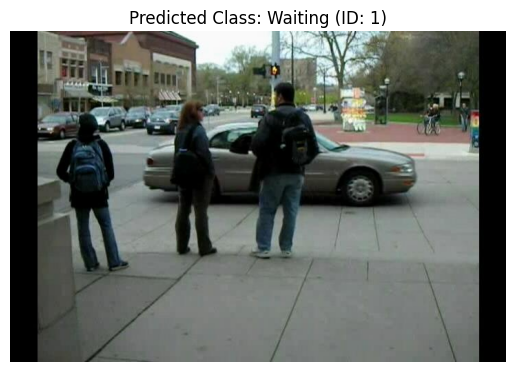

Predicted Class: Waiting (ID: 1)


In [13]:
predict_single_image(model, "C:/Users/Mukaffi/Desktop/Group-Activity-Recognition-master/data/collective/seq29/frame0414.jpg", device)

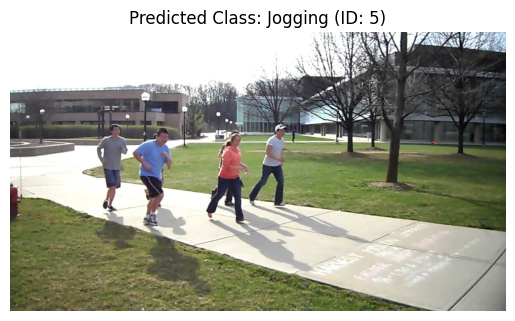

Predicted Class: Jogging (ID: 5)


In [14]:
predict_single_image(model, "C:/Users/Mukaffi/Desktop/Group-Activity-Recognition-master/data/collective/seq68/frame0004.jpg", device)

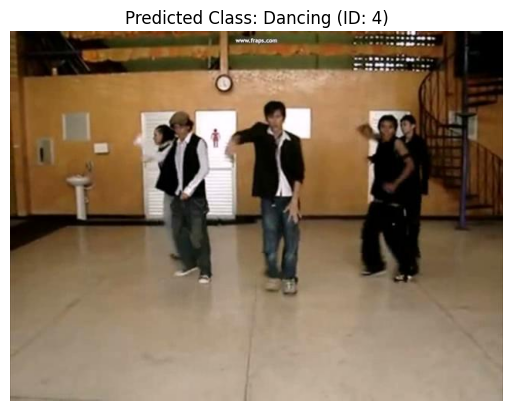

Predicted Class: Dancing (ID: 4)


In [15]:
predict_single_image(model, "C:/Users/Mukaffi/Desktop/Group-Activity-Recognition-master/data/collective/seq55/frame0004.jpg", device)

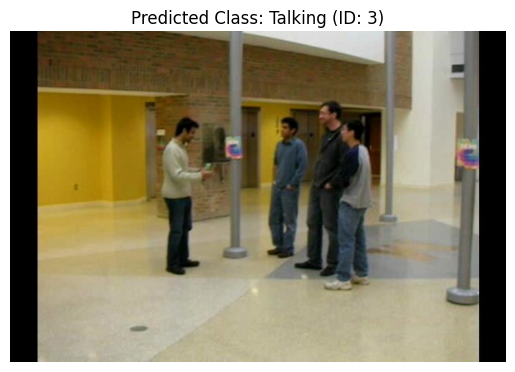

Predicted Class: Talking (ID: 3)


In [19]:
predict_single_image(model, "C:/Users/Mukaffi/Desktop/Group-Activity-Recognition-master/data/collective/seq11/frame0004.jpg", device)